# Unsupervised learning - clustering 

Cluster particle signatures into 3+ catagories. This should also be based maximum 10 variables from the Electron Variable List. In this case, there is no target variable, as this is unsupervised learning. We evaluate algorithm performance by ability of your catagories to fit into electron/non-electron classification. 

We start by opening the files and loading them into a Numpy array

In [130]:
import h5py
import pandas
from copy import deepcopy
import numpy as np
from sklearn.preprocessing import RobustScaler, QuantileTransformer
from sklearn.ensemble import GradientBoostingClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import KernelPCA




import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

In [131]:
def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        return pandas.DataFrame(f[name][:])

train = load_data('train')
test  = load_data('test')

In [132]:
## temporarily use a fraction of the data to speed everything up
#train=train.sample(frac = 0.7)

Then we can verify the shape

In [133]:
print (f'Shape of training data set: {train.shape}')
print (f'Shape of test data set: {test.shape}')

Shape of training data set: (162500, 166)
Shape of test data set: (160651, 164)


As expected, the test set contains 2 columns less: `Truth` and `p_truth_E`.
    
Then we copy the variable list from the course website <https://www.nbi.dk/~petersen/Teaching/ML2020/SmallProject/VariableList.html>

In [134]:
all_variables = ['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'correctedActualMu', 'correctedAverageMu', 'correctedScaledActualMu', 'correctedScaledAverageMu', 'NvtxReco', 'p_nTracks', 'p_pt_track', 'p_eta', 'p_phi', 'p_charge', 'p_qOverP', 'p_z0', 'p_d0', 'p_sigmad0', 'p_d0Sig', 'p_EptRatio', 'p_dPOverP', 'p_z0theta', 'p_etaCluster', 'p_phiCluster', 'p_eCluster', 'p_rawEtaCluster', 'p_rawPhiCluster', 'p_rawECluster', 'p_eClusterLr0', 'p_eClusterLr1', 'p_eClusterLr2', 'p_eClusterLr3', 'p_etaClusterLr1', 'p_etaClusterLr2', 'p_phiClusterLr2', 'p_eAccCluster', 'p_f0Cluster', 'p_etaCalo', 'p_phiCalo', 'p_eTileGap3Cluster', 'p_cellIndexCluster', 'p_phiModCalo', 'p_etaModCalo', 'p_dPhiTH3', 'p_R12', 'p_fTG3', 'p_weta2', 'p_Reta', 'p_Rphi', 'p_Eratio', 'p_f1', 'p_f3', 'p_Rhad', 'p_Rhad1', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_TRTPID', 'p_TRTTrackOccupancy', 'p_numberOfInnermostPixelHits', 'p_numberOfPixelHits', 'p_numberOfSCTHits', 'p_numberOfTRTHits', 'p_numberOfTRTXenonHits', 'p_chi2', 'p_ndof', 'p_SharedMuonTrack', 'p_E7x7_Lr2', 'p_E7x7_Lr3', 'p_E_Lr0_HiG', 'p_E_Lr0_LowG', 'p_E_Lr0_MedG', 'p_E_Lr1_HiG', 'p_E_Lr1_LowG', 'p_E_Lr1_MedG', 'p_E_Lr2_HiG', 'p_E_Lr2_LowG', 'p_E_Lr2_MedG', 'p_E_Lr3_HiG', 'p_E_Lr3_LowG', 'p_E_Lr3_MedG', 'p_ambiguityType', 'p_asy1', 'p_author', 'p_barys1', 'p_core57cellsEnergyCorrection', 'p_deltaEta0', 'p_deltaEta2', 'p_deltaEta3', 'p_deltaPhi0', 'p_deltaPhi1', 'p_deltaPhi2', 'p_deltaPhi3', 'p_deltaPhiFromLastMeasurement', 'p_deltaPhiRescaled0', 'p_deltaPhiRescaled1', 'p_deltaPhiRescaled3', 'p_e1152', 'p_e132', 'p_e235', 'p_e255', 'p_e2ts1', 'p_ecore', 'p_emins1', 'p_etconeCorrBitset', 'p_ethad', 'p_ethad1', 'p_f1core', 'p_f3core', 'p_maxEcell_energy', 'p_maxEcell_gain', 'p_maxEcell_time', 'p_maxEcell_x', 'p_maxEcell_y', 'p_maxEcell_z', 'p_nCells_Lr0_HiG', 'p_nCells_Lr0_LowG', 'p_nCells_Lr0_MedG', 'p_nCells_Lr1_HiG', 'p_nCells_Lr1_LowG', 'p_nCells_Lr1_MedG', 'p_nCells_Lr2_HiG', 'p_nCells_Lr2_LowG', 'p_nCells_Lr2_MedG', 'p_nCells_Lr3_HiG', 'p_nCells_Lr3_LowG', 'p_nCells_Lr3_MedG', 'p_pos', 'p_pos7', 'p_poscs1', 'p_poscs2', 'p_ptconeCorrBitset', 'p_ptconecoreTrackPtrCorrection', 'p_r33over37allcalo', 'p_topoetconeCorrBitset', 'p_topoetconecoreConeEnergyCorrection', 'p_topoetconecoreConeSCEnergyCorrection', 'p_weta1', 'p_widths1', 'p_widths2', 'p_wtots1', 'p_e233', 'p_e237', 'p_e277', 'p_e2tsts1', 'p_ehad1', 'p_emaxs1', 'p_fracs1', 'p_DeltaE', 'p_E3x5_Lr0', 'p_E3x5_Lr1', 'p_E3x5_Lr2', 'p_E3x5_Lr3', 'p_E5x7_Lr0', 'p_E5x7_Lr1', 'p_E5x7_Lr2', 'p_E5x7_Lr3', 'p_E7x11_Lr0', 'p_E7x11_Lr1', 'p_E7x11_Lr2', 'p_E7x11_Lr3', 'p_E7x7_Lr0', 'p_E7x7_Lr1' ]

Finally, we divide the training data into data (`X`) and targets (`y`)

Only use the entries which we know are true electrons for training.


In [135]:
#train = train.loc[train['Truth']==1]
X = train[all_variables]
y = train['Truth']

print (f'Shape of X: {X.shape}')
print (f'Shape of y: {y.shape}')

Shape of X: (162500, 160)
Shape of y: (162500,)


In [136]:
X.head(2)

,actualInteractionsPerCrossing,averageInteractionsPerCrossing,correctedActualMu,correctedAverageMu,correctedScaledActualMu,correctedScaledAverageMu,NvtxReco,p_nTracks,p_pt_track,p_eta,...,p_E5x7_Lr0,p_E5x7_Lr1,p_E5x7_Lr2,p_E5x7_Lr3,p_E7x11_Lr0,p_E7x11_Lr1,p_E7x11_Lr2,p_E7x11_Lr3,p_E7x7_Lr0,p_E7x7_Lr1
0,26.5,26.5,26.5,26.5,26.5,26.5,18,3,42011.792969,1.834715,...,215.588013,43402.332031,74045.820312,337.980713,273.708801,43091.683594,74447.539062,470.177124,273.708801,43091.683594
1,35.5,35.5,35.5,35.5,35.5,35.5,23,4,39722.859375,-1.592156,...,10502.792969,36774.925781,58228.847656,412.321869,10861.282227,37433.324219,61805.964844,460.203613,10861.282227,37433.324219


## Preprocessing

### Check null values

In [137]:
train.isnull().sum()

eventNumber                       0
runNumber                         0
actualInteractionsPerCrossing     0
averageInteractionsPerCrossing    0
correctedActualMu                 0
                                 ..
p_E7x11_Lr2                       0
p_E7x11_Lr3                       0
p_E7x7_Lr0                        0
p_E7x7_Lr1                        0
index                             0
Length: 166, dtype: int64

No nulls
### Scale the data

In [138]:
transformed_X = deepcopy(X) 
# This loop transforms every variable _independently_ 
for variable in X.columns:     
    #transformed_X[variable] = RobustScaler().fit_transform(np.array(transformed_X[variable]).reshape(-1,1))
    transformed_X[variable] = QuantileTransformer().fit_transform(np.array(transformed_X[variable]).reshape(-1,1))

### Select k Best features  
Use the electron/not electron truth field to choose the 10 best features

In [139]:
from sklearn.feature_selection import SelectKBest, f_regression, f_classif

In [140]:
X_10 = SelectKBest(score_func=f_classif, k=10).fit_transform(transformed_X,y)
X_10.shape

/opt/conda/envs/python3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 67  73  76 101 113 119 122 128 131 136] are constant.
  UserWarning)
/opt/conda/envs/python3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(162500, 10)

In [141]:
X_train, X_val, y_train, y_val = train_test_split(X_10, y, test_size=0.25, 
                                                    shuffle=True, random_state=42)

# K-Means clustering

100%|██████████| 8/8 [00:52<00:00,  6.58s/it]


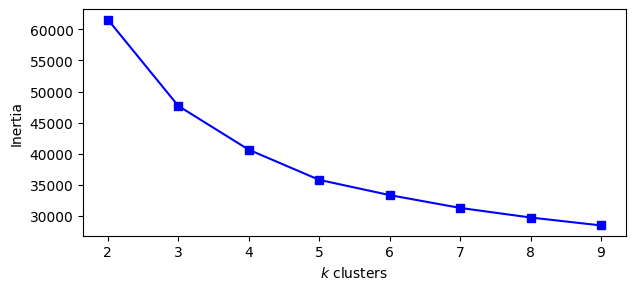

In [142]:
from sklearn.cluster import KMeans

# loop over several k values and record inertias
ks = np.arange(2, 10)
inertias = []
for k in tqdm(ks):
    kmeans = KMeans(n_clusters=k, init='k-means++', 
                    n_init=10, random_state=42)
    kmeans.fit(X_train)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
                       subplot_kw={'xlabel': '$k$ clusters', 
                                   'ylabel': 'Inertia'})
plt.plot(ks, inertias, 'bs-')
#plt.plot(3, inertias[1], 'rs')
plt.show()

In [92]:
# from sklearn.metrics import silhouette_score

# ks = np.arange(2, 10)
# scores = []
# for k in tqdm(ks):
#     kmeans = KMeans(n_clusters=k, init='k-means++', 
#                     n_init=10, random_state=42)
#     kmeans.fit(X_10)
#     scores.append(silhouette_score(X_10, kmeans.labels_))

# fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
#                        subplot_kw={'xlabel': '$k$ clusters', 
#                                    'ylabel': 'Silhouette Score'})
# plt.plot(ks, scores, 'bs-')
# #plt.plot(3, scores[1], 'rs')
# plt.show()

In [143]:
kmeans = KMeans(n_clusters=4, init='k-means++', 
                n_init=10, random_state=42)
kmeans.fit(X_train)
y_pred = kmeans.predict(X_val)

test_score = accuracy_score(y_val, y_pred)
print(f"Test score: {test_score:.3f}")

Test score: 0.339


In [145]:
for num_clus in tqdm(range(2,6)):
    kmeans = KMeans(n_clusters=num_clus, init='k-means++', 
                n_init=10, random_state=42)
    kmeans.fit(X_train)
    y_pred = kmeans.predict(X_val)

    test_score = accuracy_score(y_val, y_pred)
    print(f"Test score: {test_score:.3f}")

 25%|██▌       | 1/4 [00:01<00:04,  1.52s/it]

Test score: 0.775


 50%|█████     | 2/4 [00:03<00:03,  1.62s/it]

Test score: 0.544


 75%|███████▌  | 3/4 [00:07<00:02,  2.37s/it]

Test score: 0.339


100%|██████████| 4/4 [00:11<00:00,  2.91s/it]

Test score: 0.204


### With UMAP

100%|██████████| 8/8 [00:27<00:00,  3.38s/it]


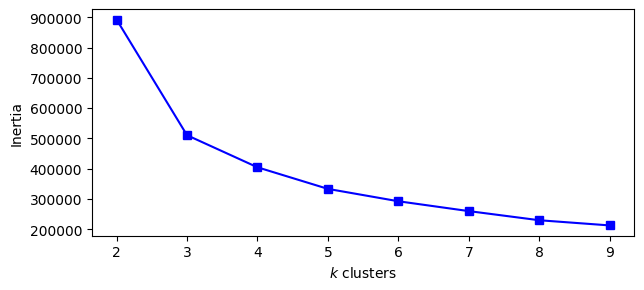

In [180]:
# loop over several k values and record inertias
ks = np.arange(2, 10)
inertias = []
for k in tqdm(ks):
    kmeans = KMeans(n_clusters=k, init='k-means++', 
                    n_init=10, random_state=42)
    kmeans.fit(X_train_umap)
    inertias.append(kmeans.inertia_)

fig, ax = plt.subplots(1, dpi=100, figsize=(7,3), 
                       subplot_kw={'xlabel': '$k$ clusters', 
                                   'ylabel': 'Inertia'})
plt.plot(ks, inertias, 'bs-')
#plt.plot(3, inertias[1], 'rs')
plt.show()

In [182]:
kmeans = KMeans(n_clusters=4, init='k-means++', 
                n_init=10, random_state=42)
kmeans.fit(X_train_umap)
y_pred_kmeans_umap = kmeans.predict(X_val_umap)

test_score = accuracy_score(y_val, y_pred_kmeans_umap)
print(f"Test score: {test_score:.3f}")

Test score: 0.595


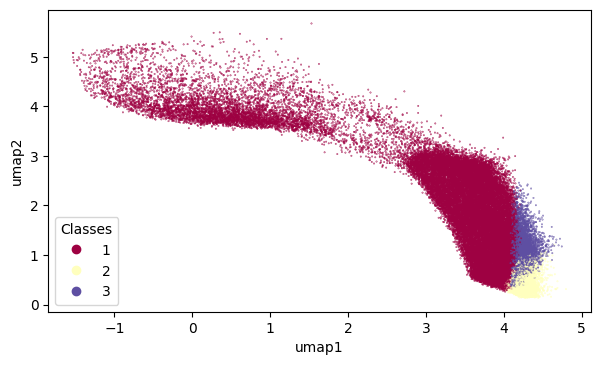

In [183]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=100,
                       subplot_kw={'xlabel': 'umap1', 
                                   'ylabel': 'umap2'})
scatter=plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1],
            c=y_pred_kmeans_umap, s=0.1, cmap='Spectral');
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

## UMAP

In [146]:
#!pip install umap-learn

In [102]:
import umap.umap_ as umap

### Standard umap parameters

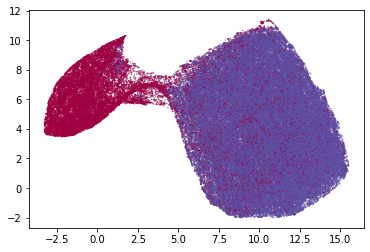

In [151]:
#standard_embedding = umap.UMAP(random_state=42).fit_transform(X_train.data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral', c=y_train);

### UMAP recommended params for clustering

In [152]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=4,
    random_state=42,
    verbose=1
)

In [153]:
X_train_umap = clusterable_embedding.fit_transform(X_train)
X_val_umap = clusterable_embedding.transform(X_val)

UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.0, n_components=4, n_epochs=None, n_jobs=-1,
     n_neighbors=30, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)
Construct fuzzy simplicial set
Sat May 22 17:00:01 2021 Finding Nearest Neighbors
Sat May 22 17:00:01 2021 Building RP forest with 22 trees
Sat May 22 17:00:02 2021 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Sat May 22 17:00:56 2021 Finished Nearest Neighbor Search
Sat May 22 17:00:59 2021 Construct em

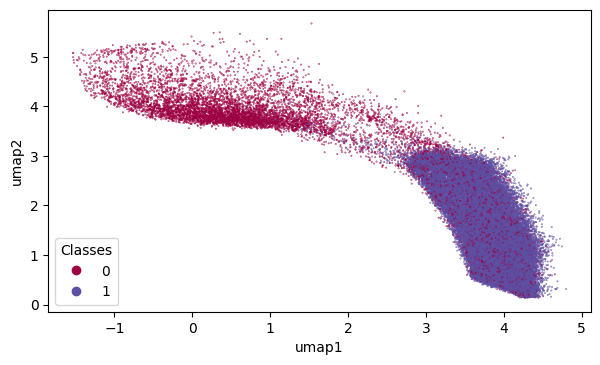

In [154]:

fig, ax = plt.subplots(1, figsize=(7,4), dpi=100,
                       subplot_kw={'xlabel': 'umap1', 
                                   'ylabel': 'umap2'})
scatter=plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1],
            c=y_val, s=0.1, cmap='Spectral');
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

In [171]:
## try using 50 features
X_50 = SelectKBest(score_func=f_classif, k=6).fit_transform(X,y)
X_50.shape

/opt/conda/envs/python3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [ 67  73  76 101 113 119 122 128 131 136] are constant.
  UserWarning)
/opt/conda/envs/python3/lib/python3.7/site-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


(162500, 6)

In [172]:
X_train50, X_val50, y_train50, y_val50 = train_test_split(X_50, y, test_size=0.25, 
                                                    shuffle=True, random_state=42)

In [173]:
X_train_umap50 = clusterable_embedding.fit_transform(X_train50)
X_val_umap50 = clusterable_embedding.transform(X_val50)


UMAP(a=None, angular_rp_forest=False, b=None, dens_frac=0.0, dens_lambda=0.0,
     dens_var_shift=0.1, densmap=False, disconnection_distance=None,
     force_approximation_algorithm=False, init='spectral', learning_rate=1.0,
     local_connectivity=1.0, low_memory=True, metric='euclidean',
     metric_kwds=None, min_dist=0.0, n_components=4, n_epochs=None, n_jobs=-1,
     n_neighbors=30, negative_sample_rate=5, output_dens=False,
     output_metric='euclidean', output_metric_kwds=None, random_state=42,
     repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
     target_metric='categorical', target_metric_kwds=None, ...)
Construct fuzzy simplicial set
Sat May 22 17:23:38 2021 Finding Nearest Neighbors
Sat May 22 17:23:38 2021 Building RP forest with 22 trees
Sat May 22 17:23:39 2021 NN descent for 17 iterations
	 1  /  17
	 2  /  17
	Stopping threshold met -- exiting after 2 iterations
Sat May 22 17:24:37 2021 Finished Nearest Neighbor Search
Sat May 22 17:24:40 2021 Construct em

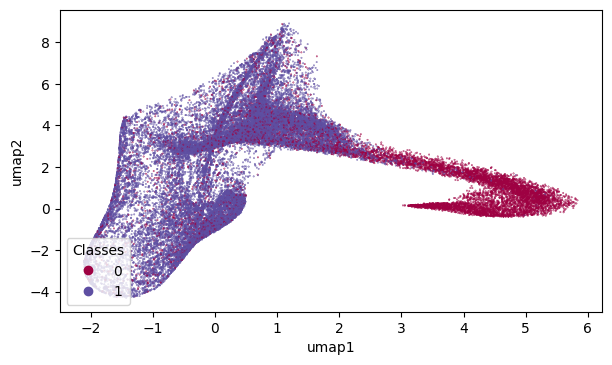

In [174]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=100,
                       subplot_kw={'xlabel': 'umap1', 
                                   'ylabel': 'umap2'})
scatter=plt.scatter(X_val_umap50[:, 0], X_val_umap50[:, 1],
            c=y_val, s=0.1, cmap='Spectral');
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

### Gaussian mixture model

### clusterable embedding

In [165]:
gm_umap = GaussianMixture(n_components=4, random_state=0).fit(X_train_umap)
y_pred_umap = gm_umap.predict(X_val_umap)

test_score_umap = accuracy_score(y_val, y_pred_umap)
print(f"Test score: {test_score_umap:.3f}")

Test score: 0.070


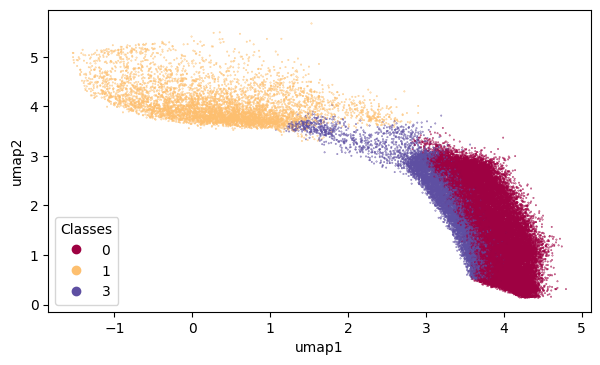

In [166]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=100,
                       subplot_kw={'xlabel': 'umap1', 
                                   'ylabel': 'umap2'})
scatter=plt.scatter(X_val_umap[:, 0], X_val_umap[:, 1],
            c=y_pred_umap, s=0.1, cmap='Spectral');
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

(array([27449.,     0.,     0.,  5766.,     0.,     0.,     0.,     0.,
            0.,  7410.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

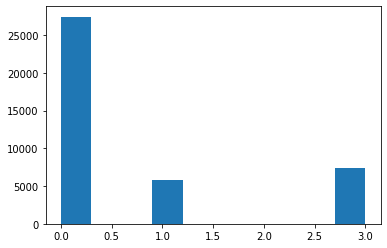

In [167]:
plt.hist(y_pred_umap)

### raw data

In [168]:
gm_umap = GaussianMixture(n_components=4, random_state=0).fit(X_train)
y_pred = gm_umap.predict(X_val)

test_score = accuracy_score(y_val, y_pred)
print(f"Test score: {test_score:.3f}")

Test score: 0.275


(array([11890.,     0.,     0., 12861.,     0.,     0., 10960.,     0.,
            0.,  4914.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

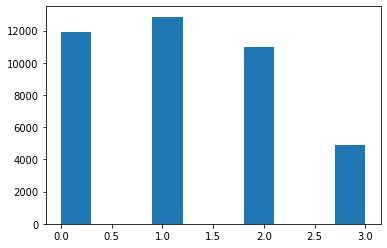

In [170]:
plt.hist(y_pred)

### Using 50 features

In [176]:
gm_umap50 = GaussianMixture(n_components=4, random_state=0).fit(X_train_umap50)
y_pred_umap50 = gm_umap50.predict(X_val_umap50)

test_score_umap50 = accuracy_score(y_val50, y_pred_umap50)
print(f"Test score: {test_score_umap50:.3f}")

Test score: 0.169


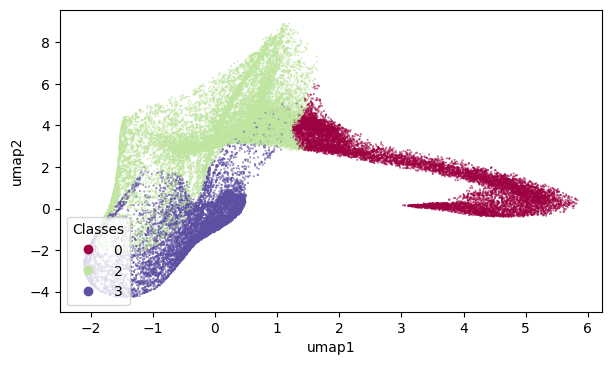

In [178]:
fig, ax = plt.subplots(1, figsize=(7,4), dpi=100,
                       subplot_kw={'xlabel': 'umap1', 
                                   'ylabel': 'umap2'})
scatter=plt.scatter(X_val_umap50[:, 0], X_val_umap50[:, 1],
            c=y_pred_umap50, s=0.1, cmap='Spectral');
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")

(array([ 9713.,     0.,     0.,     0.,     0.,     0., 20460.,     0.,
            0., 10452.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <a list of 10 Patch objects>)

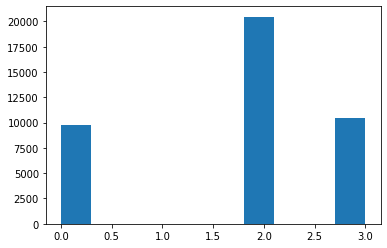

In [179]:
plt.hist(y_pred_umap50)